<a href="https://colab.research.google.com/github/Gooogr/Brain2Image/blob/master/sub_notebooks/EEG_classifier_brain_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EEG signals classifier based on MindBigData datasets<br>
MNIST of the brain: http://mindbigdata.com/opendb/index.html <br>
Imagenet of the brain: http://mindbigdata.com/opendb/imagenet.html


In [1]:
# Imports
import sys
import os
import gc
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch; torch.utils.backcompat.broadcast_warning.enabled = True
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.backends.cudnn as cudnn; cudnn.benchmark = True
from scipy.fftpack import fft, rfft, fftfreq, irfft, ifft, rfftfreq
import numpy as np

import pandas as pd
import ast

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
! nvidia-smi

Sat Oct 17 20:06:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
! ln -s "/content/drive/My Drive" "/content/mydrive"

Mounted at /content/drive


Link to the critic article:<br>
https://arxiv.org/pdf/1812.07697.pdf

Link to LSTM script from the article:<br>
http://perceive.dieei.unict.it/files/cvpr_2017_eeg_encoder.py

In [25]:
#DATASET_PATH = '/content/mydrive/EEG2Image_research/datasets/perceive_lab/eeg_signals_128_sequential_band_all_with_mean_std.pth'
#SPLIT_PATH = '/content/mydrive/EEG2Image_research/datasets/perceive_lab/block_splits_by_image.pth'
SAVE_PATH = '/content/mydrive/EEG2Image_research/models/vanila_lstm_classifier.pth'
CHKPT_FOLDER = '/content/mydrive/EEG2Image_research/models/chkpt/'

FILTERING = True       # Default - True, filter raw data
CHECKPOINT_NAME = None # Default - None, specify checkpoint path for model training

# SPLIT_NUM = 0          # Default - 0, split number
BATCH_SIZE = 16        # Default - 16, batch size
NO_CUDA = False        # Default - False, disable CUDA computation

EPOCHS = 300           # Default - 300, traning epochs number

LSTM_SIZE = 128        # Default - 128, LSTM hidden size
LSTM_LAYERS = 1        # Default - 1,  LSTM layers 
EMBEDDING_SIZE = 128   # Default - 128, embedding size
NUM_CLASSES = 10       # Default - 10, MNIST 0 - 9
OPTIM_NAME = 'Adam'    # Default - Adam, optimizer type
LR = 0.01             # Default - 0.001, learning rate 

LR_DECAY_FACTOR = 0.5  # Default - 0.5, learning rate decay factor, for SGD only
LR_DECAY_PERIOD = 10   # Default - 10  learning rate decay period, for SGD only

### Prepare dataset

In [5]:
def get_dataset(dataset_name):
    try:
        if dataset_name == 'MNIST':
            ! wget -q https://datahub.io/DavidVivancos/mindbigdata-ep-v1.0-bitter-chipmunk-96/r/mindbigdata-ep-v1.0.zip?v=1 \
                -O dataset.zip
            ! unzip -q dataset.zip
        if dataset_name == 'Imagenet':
            pass
    except:
        raise ValueError('Specify type of dataset: MNIST or Imagenet')    

 FILE FORMAT:

The data is stored in a very simple text format including:

[id]: a numeric, only for reference purposes.

[event] id, a integer, used to distinguish the same event captured at different brain locations, used only by multichannel devices (all except MW).

[device]: a 2 character string, to identify the device used to capture the signals, "MW" for MindWave, "EP" for Emotive Epoc, "MU" for Interaxon Muse & "IN" for Emotiv Insight.

[channel]: a string, to indentify the 10/20 brain location of the signal, with possible values:
 
	MindWave 	"FP1"
	EPOC 	"AF3, "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"
	Muse 	"TP9,"FP1","FP2", "TP10"
	Insight 	"AF3,"AF4","T7","T8","PZ" 

[code]: a integer, to indentify the digit been thought/seen, with possible values 0,1,2,3,4,5,6,7,8,9 or -1 for random captured signals not related to any of the digits.

[size]: a integer, to identify the size in number of values captured in the 2 seconds of this signal, since the Hz of each device varies, in "theory" the value is close to 512Hz for MW, 128Hz for EP, 220Hz for MU & 128Hz for IN, for each of the 2 seconds.

[data]: a coma separated set of numbers, with the time-series amplitude of the signal, each device uses a different precision to identify the electrical potential captured from the brain: integers in the case of MW & MU or real numbers in the case of EP & IN. 

In [6]:
get_dataset('MNIST')

In [7]:
def txt2float(s):
    '''
    Convert text string to numpy array with float32 dtype.
    '''
    row = list(ast.literal_eval(s))
    result = np.array(row, dtype=np.float32)
    return result

In [8]:
%%time 
column_names = ['id', 'event', 'device', 'channel', 'code', 'size', 'data']
df = pd.read_table('./EP1.01.txt', names=column_names) #delim_whitespace=True, 
print('Shape of the dataset:', df.shape)
df.data = df.data.apply(txt2float)

Shape of the dataset: (910476, 7)
CPU times: user 6min 13s, sys: 15.6 s, total: 6min 28s
Wall time: 6min 31s


In [9]:
gc.collect()

363

In [10]:
df.head(15)

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"[4395.385, 4382.564, 4377.436, 4387.1797, 4395..."
1,67636,67635,EP,F7,6,260,"[4489.231, 4475.385, 4474.359, 4486.6665, 4498..."
2,67637,67635,EP,F3,6,260,"[4538.4614, 4528.718, 4524.615, 4526.154, 4532..."
3,67638,67635,EP,FC5,6,260,"[4207.6924, 4205.641, 4200.5127, 4194.359, 419..."
4,67639,67635,EP,T7,6,260,"[4497.9487, 4498.4614, 4494.8716, 4497.9487, 4..."
5,67640,67635,EP,P7,6,260,"[4203.077, 4192.8203, 4194.8716, 4204.615, 420..."
6,67641,67635,EP,O1,6,260,"[4203.077, 4193.3335, 4194.8716, 4207.1797, 42..."
7,67642,67635,EP,O2,6,260,"[4229.7437, 4216.923, 4207.1797, 4215.385, 423..."
8,67643,67635,EP,P8,6,260,"[4245.641, 4236.41, 4218.4614, 4220.0, 4239.48..."
9,67644,67635,EP,T8,6,260,"[4506.6665, 4501.026, 4496.923, 4496.923, 4504..."


In [11]:
print('Channels amount:', df.groupby(['event']).agg({'channel': 'nunique'})['channel'].unique())

Channels amount: [14]


Every event has 14 channels

In [63]:
# random_event = np.random.choice(df.event.unique())
# data_sample = df[df['event'] == 67635]
# fig = plt.figure(figsize=(15, 5))
# for row in data_sample['data']:
#     plt.plot(row)
# plt.title('Random EGG signal based on 14 Emotive EPOC sensors (event №{})'.format(random_event))    
# plt.show()     

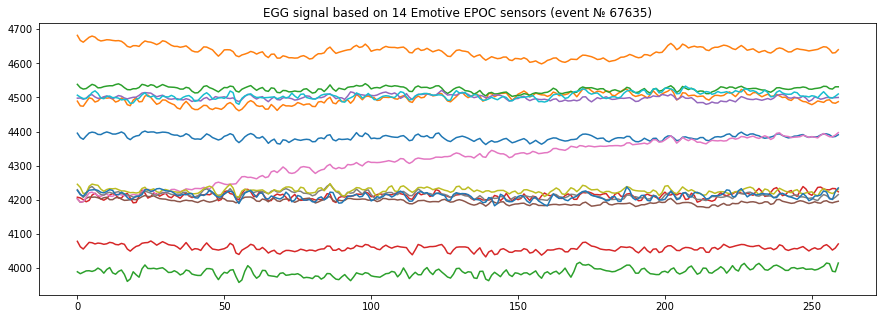

In [64]:
data_sample = df[df['event'] == 67635]
fig = plt.figure(figsize=(15, 5))
for row in data_sample['data']:
    plt.plot(row)
plt.title('EGG signal based on 14 Emotive EPOC sensors (event № 67635)')    
plt.show()  

In [13]:
np.all(df['size'].values == 260)

False

In [14]:
df['size'].value_counts()

260    606214
256    173614
264     61586
261     44072
257     12362
252      4956
265      3640
268      2884
253       294
272       196
248       196
269        98
249        70
276        56
244        42
292        28
204        14
196        14
228        14
212        14
224        14
320        14
232        14
240        14
273        14
280        14
284        14
136        14
Name: size, dtype: int64

Filter values signal length. We need events with length qual to 260.

In [15]:
# Find events with 260 length
clear_grouping = df[df['size'] == 260].groupby('event').agg({'id':'nunique'})
# Save only complete events with 14 channels (sanity check)
correct_events = clear_grouping[clear_grouping['id'] == 14].index
# Filter data
filtered_df = df[df['event'].isin(correct_events)]

In [16]:
filtered_df.head()

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"[4395.385, 4382.564, 4377.436, 4387.1797, 4395..."
1,67636,67635,EP,F7,6,260,"[4489.231, 4475.385, 4474.359, 4486.6665, 4498..."
2,67637,67635,EP,F3,6,260,"[4538.4614, 4528.718, 4524.615, 4526.154, 4532..."
3,67638,67635,EP,FC5,6,260,"[4207.6924, 4205.641, 4200.5127, 4194.359, 419..."
4,67639,67635,EP,T7,6,260,"[4497.9487, 4498.4614, 4494.8716, 4497.9487, 4..."


In [17]:
targets = filtered_df.groupby('event')['code'].mean().values #It is not important mean, max or min
print('Targets amount', len(targets))

Targets amount 43301


In [68]:
# Stack sub-arrays and transpond matrix 
t_data = np.vstack(filtered_df['data'].values).T
print(t_data.shape)

(260, 606214)


In [69]:
# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(t_data)

In [70]:
#split data to 43301 batches (14 columns in a batch)
data = np.array(np.split(scaled_data, 43301, axis=1)) 

In [71]:
print('Final dataset shape:', data.shape)

Final dataset shape: (43301, 260, 14)


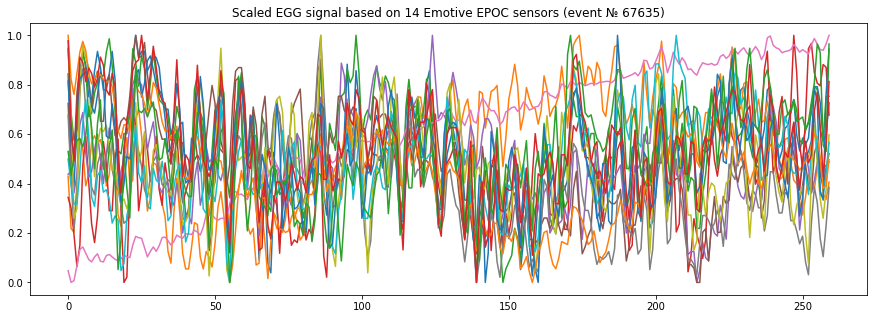

In [72]:
data_sample = data[0, ...]
fig = plt.figure(figsize=(15, 5))
for idx in range(data_sample.shape[1]):
    plt.plot(data_sample[:, idx])                                                 
plt.title('Scaled EGG signal based on 14 Emotive EPOC sensors (event № 67635)')    
plt.show() 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


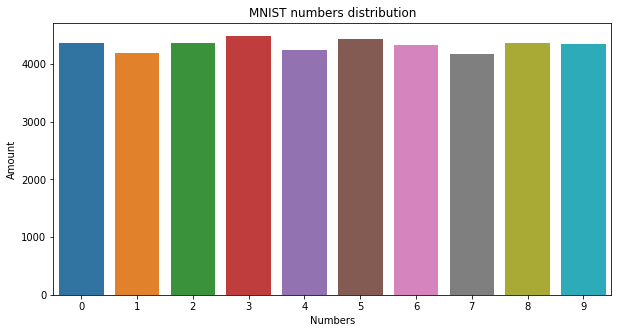

In [74]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(targets)
ax.set(xlabel='Numbers', ylabel='Amount')
plt.title('MNIST numbers distribution')
plt.show()

Dataset seems quite balanced. Let's make index partition.

In [75]:
idx_full = list(range(len(data)))

In [76]:
idx_rest, idx_val, y_rest, y_val = train_test_split(idx_full, targets, test_size=0.1, stratify=targets)
idx_train, idx_test, y_train, y_test = train_test_split(idx_rest, y_rest, test_size=0.1, stratify=y_rest)

In [77]:
print(len(y_train), len(y_val), len(y_test))

35073 4331 3897


Data generator example: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [78]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        idx = self.list_IDs[index]

        # Load data
        X = data[idx, :, :]
        y = self.labels[index]

        return X, y

In [79]:
training_set = Dataset(idx_train, y_train)
training_generator = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

validation_set = Dataset(idx_val, y_val)
validation_generator = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_set = Dataset(idx_test, y_test)
test_generator = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [80]:
loaders = {'train': training_generator, 'val': validation_generator, 'test': test_generator}
                      

In [81]:
egg_sample, label_sample = next(iter(training_set))
print("Samples amount, ms: {}; channels amount: {}".format(*egg_sample.shape))
print("Label:", label_sample)


Samples amount, ms: 260; channels amount: 14
Label: 1


In [82]:
# Define model
class Model(nn.Module):

    def __init__(self, input_size, lstm_size, lstm_layers, embedding_size, num_classes):
        # Call parent
        super().__init__()
        # Define parameters
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.lstm_layers = lstm_layers
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        # Define internal modules
        self.lstm = nn.LSTM(input_size, lstm_size, num_layers=lstm_layers, batch_first=True)
        self.embedding = nn.Linear(lstm_size, embedding_size)
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        # Prepare LSTM initiale state
        batch_size = x.size(0)
        # Forward LSTM and get final state
        x = self.lstm(x)[0][:,-1,:]
        # Forward embedding
        x = F.relu(self.embedding(x))
        # Forward classifier
        x = self.classifier(x)
        return x

In [83]:
model = Model(14, LSTM_SIZE, LSTM_LAYERS, EMBEDDING_SIZE, NUM_CLASSES)
optimizer = getattr(torch.optim, OPTIM_NAME)(model.parameters(), lr = LR)

In [84]:
start_epoch = 1 # default counter for traning loop

# if CHECKPOINT_NAME is not None:
#     checkpoint = torch.load(os.path.join(CHKPT_FOLDER, CHECKPOINT_NAME))
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     start_epoch = checkpoint['epoch']
#     loss = checkpoint['loss']

In [ ]:
# Setup CUDA
if not NO_CUDA:
    model.cuda()
    print("Copied to CUDA")

# Start training
for epoch in range(start_epoch, EPOCHS+1):
    # Initialize loss/accuracy variables
    losses = {"train": 0, "val": 0, "test": 0}
    accuracies = {"train": 0, "val": 0, "test": 0}
    counts = {"train": 0, "val": 0, "test": 0}
    # Adjust learning rate for SGD
    if OPTIM_NAME == "SGD":
        lr = LR * (LR_DECAY_FACTOR ** (epoch // LR_DECAY_PERIOD))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    # Process each split
    for split in ("train", "val", "test"):
        # Set network mode
        if split == "train":
            model.train()
            torch.set_grad_enabled(True)
        else:
            model.eval()
            torch.set_grad_enabled(False)
        # Process all split batches
        for i, (input, target) in enumerate(loaders[split]):
            # Check CUDA
            if not NO_CUDA:
                input = input.cuda(async = True)
                target = target.cuda(async = True)
            # Forward
            output = model(input)
            loss = F.cross_entropy(output, target)
            losses[split] += loss.item()
            # Compute accuracy
            _,pred = output.data.max(1)
            correct = pred.eq(target.data).sum().item()
            accuracy = correct/input.data.size(0)
            accuracies[split] += accuracy
            counts[split] += 1
            # Backward and optimize
            if split == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    ## Save checkpoint
    # if epoch % 10 == 0:
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': loss
    #     }, os.path.join(CHKPT_FOLDER, 'vanila_lstm_chkpt_epoch_{}.pt'.format(epoch)))

    # Print info at the end of the epoch
    print("Epoch {0}: TrL={1:.4f}, TrA={2:.4f}, VL={3:.4f}, VA={4:.4f}, TeL={5:.4f}, TeA={6:.4f}".format(epoch,
                                                                                                         losses["train"]/counts["train"],
                                                                                                         accuracies["train"]/counts["train"],
                                                                                                         losses["val"]/counts["val"],
                                                                                                         accuracies["val"]/counts["val"],
                                                                                                         losses["test"]/counts["test"],
                                                                                                         accuracies["test"]/counts["test"]))

Copied to CUDA


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: This overload of cuda is deprecated:
	cuda(torch.device device, bool async, *, torch.memory_format memory_format)
Consider using one of the following signatures instead:
	cuda(torch.device device, bool non_blocking, *, torch.memory_format memory_format) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


Epoch 1: TrL=2.3046, TrA=0.1008, VL=2.3048, VA=0.1009, TeL=2.3049, TeA=0.1008
Epoch 2: TrL=2.3044, TrA=0.1016, VL=2.3028, VA=0.1007, TeL=2.3028, TeA=0.1006
Epoch 3: TrL=2.3040, TrA=0.1023, VL=2.3051, VA=0.1007, TeL=2.3052, TeA=0.1008
Epoch 4: TrL=2.3046, TrA=0.1001, VL=2.3030, VA=0.1009, TeL=2.3030, TeA=0.1003
Epoch 5: TrL=2.3044, TrA=0.1005, VL=2.3042, VA=0.1037, TeL=2.3042, TeA=0.1039
Epoch 6: TrL=2.3043, TrA=0.1011, VL=2.3060, VA=0.1037, TeL=2.3060, TeA=0.1037
Epoch 7: TrL=2.3044, TrA=0.1003, VL=2.3045, VA=0.0963, TeL=2.3045, TeA=0.0967
Epoch 8: TrL=2.3043, TrA=0.1016, VL=2.3041, VA=0.1025, TeL=2.3042, TeA=0.1024


In [ ]:
# torch.save(model, SAVE_PATH)